# Designing a power divider for wireless communications part 1: Low-pass resonator

The power divider is a key component in modern wireless communications systems. It is usually subject to key performance metrics such as low insertion loss, minimal crosstalk between output ports, and a small footprint. In addition, low pass or bandpass filters are typically incorporated in order to suppress unwanted harmonics and noise in wireless signals. These filters should have a sharp response, quantified by the roll-off rate (ROR), and a wide stopband. 

In this 3-part notebook series, we will simulate various stages of the design process of a Wilkinson power divider (WPD) created by Moloudian et al in [1]. 
* In part one (this notebook), we start with a simple low pass filter design and improve its filter response in order to achieve a higher roll-off rate (ROR).
* In [part two](https://www.flexcompute.com/tidy3d/examples/notebooks/WPDHarmonicSuppression2/), we will add a harmonic suppression circuit to the low pass filter to achieve a wide stopband.
* In [part three](https://www.flexcompute.com/tidy3d/examples/notebooks/WPDHarmonicSuppression3/), we will implement the full WPD design and compare its performance to a conventional WPD. 

<center><img src="./img/wpdhs_1_render.png" width=480 /></center>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.rf as rf
from tidy3d.plugins.dispersion import FastDispersionFitter

td.config.logging.level = "ERROR"

## General Parameters and Mediums

The target cutoff frequency of the low pass filter is 1.8 GHz (within the GSM band) and the simulation will cover 0.1 to 8 GHz.  The `bandwidth` of the simulation is defined using the `FreqRange` utility class. 

In [2]:
(f_min, f_max) = (0.1e9, 8e9)
bandwidth = td.FreqRange.from_freq_interval(f_min, f_max)
f0 = bandwidth.freq0
freqs = bandwidth.freqs(num_points=401)

The substrate is FR4 and the metallic traces are copper. We assume both materials have constant non-zero loss across the bandwidth: loss tangent of 0.022 for FR4 and conductivity of 6E7 S/m (i.e. 60 S/um) for copper. 

In [3]:
med_FR4 = FastDispersionFitter.constant_loss_tangent_model(4.4, 0.022, (f_min, f_max))
med_Cu = rf.LossyMetalMedium(conductivity=60, frequency_range=(f_min, f_max))

Output()

## Basic resonator

The basic low pass filter uses a LC resonator design shown below. The geometric lengths and widths of each metallic patch determines its equivalent inductance and capacitance. 

<center><img src="./img/wpdhs_1_schematic.png" width=300 /></center>

The figure above is taken from Figure 2 in [1].

### Geometry and Structure

Using the dimensions provided in [1], we recreate the resonator structure below. 

In [4]:
# Geometry dimensions
mm = 1000  # Conversion factor micron to mm
H = 0.8 * mm  # Substrate thickness
T = 0.035 * mm  # Metal thickness
WL = 0.5 * mm  # Line width
LL1, LL2, LL3 = (5.8 * mm, 1.2 * mm, 11.1 * mm)  # Line lengths
WC, LC = (4 * mm, 5.3 * mm)  # Patch dimensions
Lsub, Wsub = (LL1 + WL + LL3, 2 * (LC + WL + LL2))  # Substrate dimensions

In [5]:
# Resonator geometry
geom_C = td.Box.from_bounds(rmin=(-WC / 2, 0, 0), rmax=(WC / 2, LC, T))
geom_L2 = td.Box.from_bounds(rmin=(-WL / 2, -LL2 - WL, 0), rmax=(WL / 2, 0, T))
geom_L1 = td.Box.from_bounds(rmin=(-WL / 2 - LL1, -LL2 - WL, 0), rmax=(-WL / 2, -LL2, T))
geom_L3 = td.Box.from_bounds(rmin=(WL / 2, -LL2 - WL, 0), rmax=(WL / 2 + LL3, -LL2, T))
geom_resonator_basic = td.GeometryGroup(geometries=[geom_C, geom_L1, geom_L2, geom_L3])

# Substrate and ground plane geometry
x0, y0, z0 = geom_resonator_basic.bounding_box.center  # center (x,y) with circuit
geom_gnd = td.Box(center=(x0, y0, -H - T / 2), size=(Lsub, Wsub, T))
geom_sub = td.Box(center=(x0, y0, -H / 2), size=(Lsub, Wsub, H))

In [6]:
# create structures
str_sub = td.Structure(geometry=geom_sub, medium=med_FR4)
str_gnd = td.Structure(geometry=geom_gnd, medium=med_Cu)
str_resonator_basic = td.Structure(geometry=geom_resonator_basic, medium=med_Cu)

str_list_basic = [str_sub, str_gnd, str_resonator_basic]  # List of structures

### Monitors and Ports

We define an in-plane field monitor for visualization purposes. 

In [7]:
# Field Monitors
mon_1 = td.FieldMonitor(
    center=(0, 0, 0),
    size=(td.inf, td.inf, 0),
    freqs=[f_min, f0, f_max],
    name="field in-plane",
)

The structure is terminated with two 50 ohm lumped ports.

In [8]:
# Lumped port
lp_options = {"size": (0, WL, H), "voltage_axis": 2, "impedance": 50}
LP1 = rf.LumpedPort(center=(-WL / 2 - LL1, -WL / 2 - LL2, -H / 2), name="LP1", **lp_options)
LP2 = rf.LumpedPort(center=(WL / 2 + LL3, -WL / 2 - LL2, -H / 2), name="LP2", **lp_options)
port_list = [LP1, LP2]  # List of ports

### Grid and Boundary

By default, the simulation boundary is open (PML) on all sides. We add quarter-wavelength padding on all sides to ensure the boundaries do not encroach on the near-field. 

In [9]:
# Add padding
padding = td.C_0 / f0 / 2
sim_LX = Lsub + padding
sim_LY = Wsub + padding
sim_LZ = H + padding

We use `LayerRefinementSpec` to automatically refine the grid along corners and edges of the metallic resonator. The rest of the grid is automatically created with the minimum grid size determined by the wavelength. 

In [10]:
# Layer refinement on resonator
lr_spec = rf.LayerRefinementSpec.from_structures(
    structures=[str_resonator_basic],
    min_steps_along_axis=1,
    corner_refinement=td.GridRefinement(dl=T, num_cells=2),
)

# Define overall grid spec
grid_spec = td.GridSpec.auto(
    wavelength=td.C_0 / f0,
    min_steps_per_wvl=12,
    layer_refinement_specs=[lr_spec],
)

### Simulation and TerminalComponentModeler

We define the `Simulation` and `TerminalComponentModeler` objects below. The latter facilitates a batch port sweep in order to compute the full S-parameter matrix.

In [11]:
# Define simulation object
sim = td.Simulation(
    center=(x0, y0, z0),
    size=(sim_LX, sim_LY, sim_LZ),
    structures=str_list_basic,
    grid_spec=grid_spec,
    monitors=[mon_1],
    run_time=5e-9,
    plot_length_units="mm",
)

In [12]:
# Define TerminalComponentModeler
tcm = rf.TerminalComponentModeler(
    simulation=sim,
    ports=port_list,
    freqs=freqs,
    remove_dc_component=False,
)

### Visualization

Before running, it is a good idea to check the structure layout and simulation grid. 

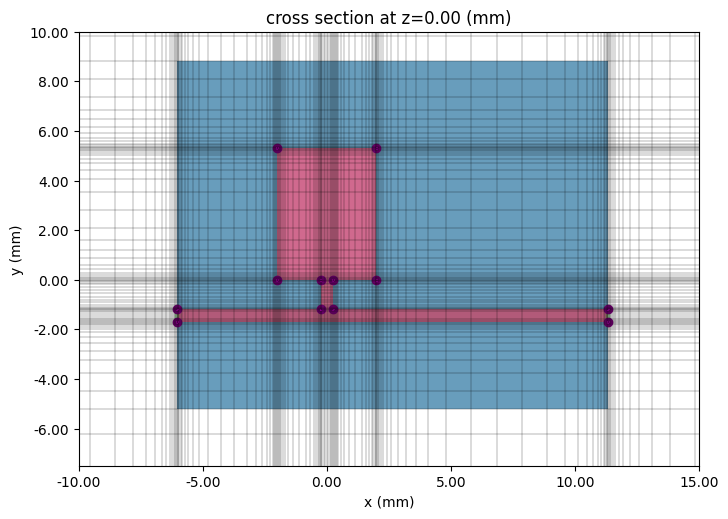

In [13]:
# In-plane
fig, ax = plt.subplots(figsize=(8, 6))
tcm.plot_sim(z=0, ax=ax, monitor_alpha=0)
tcm.simulation.plot_grid(z=0, ax=ax, hlim=(-10 * mm, 15 * mm), vlim=(-7.5 * mm, 10 * mm))
plt.show()

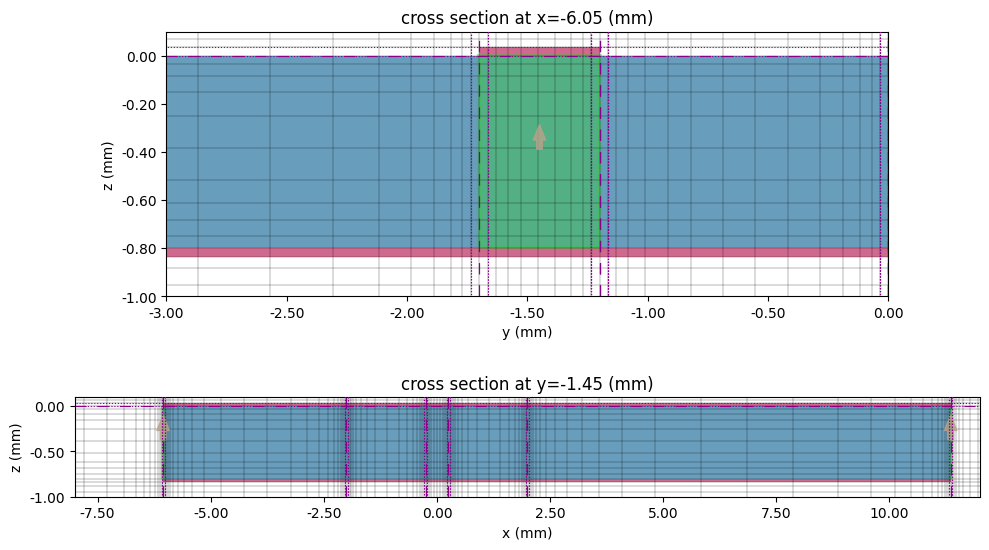

In [14]:
# Cross section and port
fig, ax = plt.subplots(2, 1, figsize=(10, 6), tight_layout=True)
tcm.plot_sim(x=-LL1 - WL / 2, ax=ax[0], monitor_alpha=0)
tcm.simulation.plot_grid(
    x=-LL1 - WL / 2, ax=ax[0], hlim=(-3 * mm, 0 * mm), vlim=(-1 * mm, 0.1 * mm)
)
tcm.plot_sim(y=-LL2 - WL / 2, ax=ax[1], monitor_alpha=0)
tcm.simulation.plot_grid(
    y=-LL2 - WL / 2, ax=ax[1], hlim=(-8 * mm, 12 * mm), vlim=(-1 * mm, 0.1 * mm)
)
ax[1].set_aspect(2)
plt.show()

### Running the Simulation

The `tidy3d.web.run()` method executes the job and downloads the simulation data after completion. 

In [15]:
tcm_data_basic = td.web.run(tcm, task_name="WPD basic resonator", path="data/tcm_data_basic.hdf5")

16:40:47 EST Created task 'WPD basic resonator' with resource_id                
             'sid-b1ee4ada-11f5-4d18-b026-3ff9fd697543' and task_type           
             'TERMINAL_CM'.

             View task using web UI at                                          
             ]8;id=916001;https://tidy3d.simulation.cloud/rf?taskId=pa-2c140dfc-f64b-420b-b7f0-102a829ab8f9\'https://tidy3d.simulation.cloud/rf?]8;;\]8;id=174352;https://tidy3d.simulation.cloud/rf?taskId=pa-2c140dfc-f64b-420b-b7f0-102a829ab8f9\taskId]8;;\]8;id=916001;https://tidy3d.simulation.cloud/rf?taskId=pa-2c140dfc-f64b-420b-b7f0-102a829ab8f9\=]8;;\]8;id=820847;https://tidy3d.simulation.cloud/rf?taskId=pa-2c140dfc-f64b-420b-b7f0-102a829ab8f9\pa]8;;\]8;id=916001;https://tidy3d.simulation.cloud/rf?taskId=pa-2c140dfc-f64b-420b-b7f0-102a829ab8f9\-2c140dfc-f64b-420b-b7]8;;\
             ]8;id=916001;https://tidy3d.simulation.cloud/rf?taskId=pa-2c140dfc-f64b-420b-b7f0-102a829ab8f9\f0-102a829ab8f9']8;;\.

             Task folder: ]8;id=334096;https://tidy3d.simulation.cloud/folders/f89aec3e-3357-4624-9c24-096a87582f12\'default']8;;\.

Output()

16:40:56 EST Maximum FlexCredit cost: 0.142. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' after run.

16:40:57 EST Subtasks status - WPD basic resonator                              
             Group ID: 'pa-2c140dfc-f64b-420b-b7f0-102a829ab8f9'

Output()

             Batch status = preprocess

16:41:04 EST Batch status = running

16:41:44 EST Batch status = postprocess

16:41:55 EST Modeler has finished running successfully.

             Billed flex credit cost: 0.050.

Output()

16:41:58 EST Loading component modeler data from data/tcm_data_basic.hdf5

### Results

#### Field Profile

The `TerminalComponentModelerData` instance returned by `tidy3d.web.run()` stores the monitor data for each port in a dictionary in the `data` attribute. Use the corresponding port name to access it. 

In [16]:
sim_data = tcm_data_basic.data["LP1"]

The in-plane field magnitude is plotted below at `f_min` and `f0`, showing a clear difference between the pass- and stopbands.

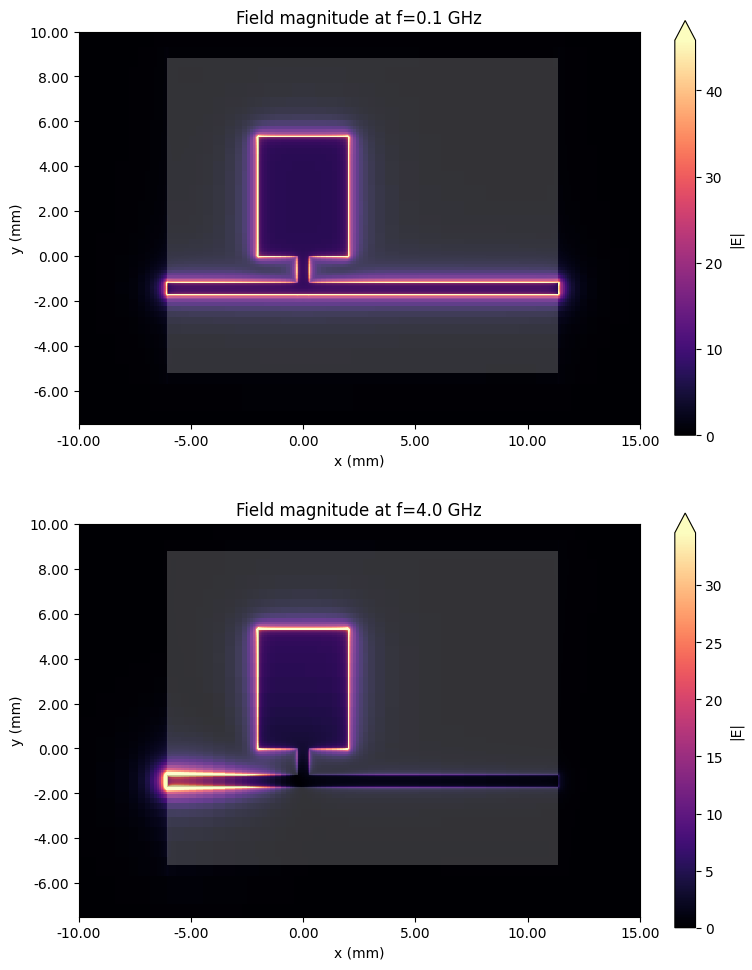

In [17]:
# Field plots
fig, ax = plt.subplots(2, 1, figsize=(8, 10), tight_layout=True)
sim_data.plot_field("field in-plane", "E", val="abs", f=f_min, ax=ax[0])
ax[0].set_title(f"Field magnitude at f={f_min / 1e9:.1f} GHz")
sim_data.plot_field("field in-plane", "E", val="abs", f=f0, ax=ax[1])
ax[1].set_title(f"Field magnitude at f={f0 / 1e9:.1f} GHz")
for axis in ax:
    axis.set_xlim(-10 * mm, 15 * mm)
    axis.set_ylim(-7.5 * mm, 10 * mm)
plt.show()

#### S-parameters

Use the `smatrix()` method to calculate the S-matrix.

In [18]:
smat = tcm_data_basic.smatrix()

We use the `port_in` and `port_out` coordinates to access the specific S-parameter from the full matrix. Note the use of `np.conjugate()` to convert from the default physics phase convention to the engineering convention. 

In [19]:
S11 = np.conjugate(smat.data.isel(port_in=0, port_out=0))
S21 = np.conjugate(smat.data.isel(port_in=0, port_out=1))
S11dB = 20 * np.log10(np.abs(S11))
S21dB = 20 * np.log10(np.abs(S21))

The insertion and return losses are plotted below.

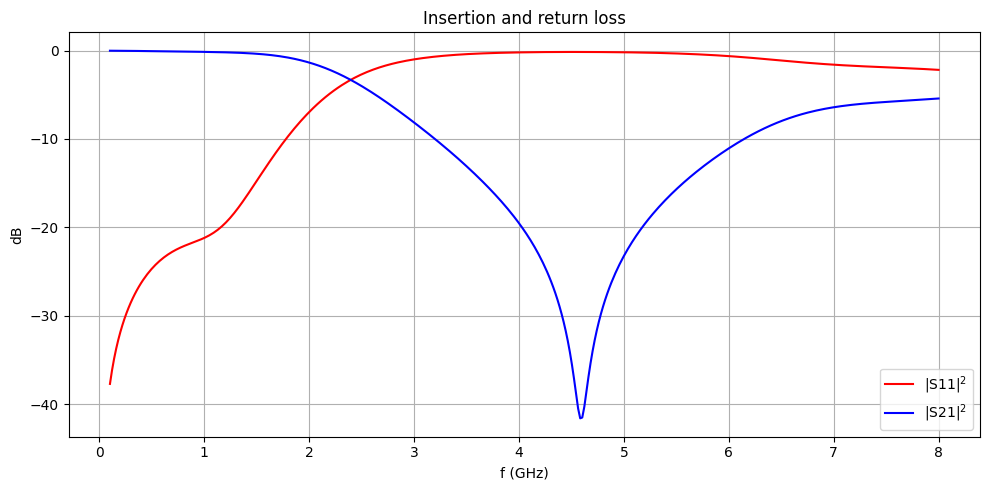

In [20]:
fig, ax = plt.subplots(figsize=(10, 5), tight_layout=True)
ax.plot(freqs / 1e9, S11dB, "r", label="|S11|$^2$")
ax.plot(freqs / 1e9, S21dB, "b", label="|S21|$^2$")
ax.set_title("Insertion and return loss")
ax.set_xlabel("f (GHz)")
ax.set_ylabel("dB")
ax.legend()
ax.grid()
plt.show()

#### Roll-off rate 

The roll-off rate (ROR) is a figure of merit that quantifies the sharpness of the filter response. It is calculated by
$$
  ROR = \frac{\Delta \alpha}{\Delta f}
$$
where $\Delta \alpha$ is the difference in insertion loss (in dB) between two reference levels and $\Delta f$ is the corresponding difference in frequency. We choose -3 and -30 dB to be the two reference levels for this calculation.

In [21]:
def calculate_ROR(SdB):
    """Calculates ROR from input S-parameter (in dB)"""
    refdB_1 = -3
    refdB_2 = -30
    f1 = np.min(freqs[np.argsort(np.abs(SdB - refdB_1))][:2])
    f2 = np.min(freqs[np.argsort(np.abs(SdB - refdB_2))][:2])
    return (refdB_2 - refdB_1) / (f1 - f2) * 1e9  # in dB/GHz

In [22]:
print(f"ROR of basic LC resonator: {calculate_ROR(S21dB):.2f} dB/GHz")

ROR of basic LC resonator: 13.02 dB/GHz


## Modified resonator

In the modified resonator, additional holes are cut into the resonator patch in order to create equivalent inductive and capacitive elements shown below. The patch is also adjusted to have a symmetric structure. 

<center><img src="./img/wpdhs_1_schematic_2.png" width=600 /></center>

The figure above is taken from Figure 3 in [1].

### Geometry and Structure

The dimensions of the resonator are mostly obtained from [1]. Missing dimensions are obtained via visual estimation. 

In [23]:
# Modified resonator dimensions
MA, MB, MC, MD = (3.9 * mm, 7.1 * mm, 3.1 * mm, 2.3 * mm)
ME, MF, MG, MH = (0.6 * mm, 0.2 * mm, 1.2 * mm, 0.5 * mm)
MJ, MK, MM, MN = (4.8 * mm, 0.3 * mm, 0.1 * mm, 0.7 * mm)
MP, MQ, MR, MS = (0.1 * mm, 0.7 * mm, 0.4 * mm, 0.3 * mm)
Lsub2, Wsub2 = (2 * MC + MH, 2 * (MH + MK + MB))

The geometry and structures are created below. To "cut" holes in the patch resonator, we first create the hole geometry, then use the `-` operator apply the Boolean difference operation onto the main patch. 

In [24]:
# Resonator geometry
geom_patch = td.Box.from_bounds(rmin=(-MA / 2, MH / 2 + MK, 0), rmax=(MA / 2, MH / 2 + MK + MB, T))
geom_hole1 = td.Box.from_bounds(
    rmin=(-MH / 2 - MN - MF - ME, MH / 2 + MK + MS, 0),
    rmax=(-MH / 2 - MN - MF, MH / 2 + MK + MS + MG, T),
)
geom_hole2 = geom_hole1.translated(2 * (MF + MN) + MH + ME, 0, 0)
geom_hole3 = td.Cylinder(center=(0, MH / 2 + MD + MQ, T / 2), radius=MR, length=T, axis=2)
geom_hole4 = geom_hole3.translated(0, MQ + 2 * MR, 0)
geom_hole5 = td.Box.from_bounds(
    rmin=(-MA / 2 + 1.5 * MF, MH / 2 + MK + MS + MG + MQ, 0),
    rmax=(-MA / 2 + 1.5 * MF + MM, MH / 2 + MK + MB - MP, T),
)
geom_hole6 = geom_hole5.translated(-2 * geom_hole5.center[0], 0, 0)
geom_hole7 = td.Box.from_bounds(
    rmin=(-MH / 2 - MN, MH / 2 + MK, 0), rmax=(MH / 2 + MN, MH / 2 + MD, T)
)
for hole in [geom_hole1, geom_hole2, geom_hole3, geom_hole4, geom_hole5, geom_hole6, geom_hole7]:
    geom_patch -= hole

geom_line1 = td.Box.from_bounds(rmin=(-MH / 2, MH / 2, 0), rmax=(MH / 2, MH / 2 + MD, T))
geom_line2 = td.Box.from_bounds(rmin=(-MH / 2 - MC, -MH / 2, 0), rmax=(MH / 2 + MC, MH / 2, T))
geom_resonator_modified = td.GeometryGroup(geometries=[geom_line1, geom_line2, geom_patch])

# Substrate and ground
x1, y1, z1 = geom_resonator_modified.bounding_box.center
geom_sub2 = td.Box(center=(x1, y1, -H / 2), size=(Lsub2, Wsub2, H))
geom_gnd2 = td.Box(center=(x1, y1, -H - T / 2), size=(Lsub2, Wsub2, T))

# Structures
str_resonator_modified = td.Structure(geometry=geom_resonator_modified, medium=med_Cu)
str_sub2 = td.Structure(geometry=geom_sub2, medium=med_FR4)
str_gnd2 = td.Structure(geometry=geom_gnd2, medium=med_Cu)
str_list_modified = [str_sub2, str_gnd2, str_resonator_modified]

### Ports

As before, we use 50 ohm lumped ports to terminate both ends of the feed line. Their positions are slightly shifted to account for the modified geometry.  

In [25]:
# Lumped port
lp_options = {"size": (0, MH, H), "voltage_axis": 2, "impedance": 50}
LP1 = rf.LumpedPort(center=(-MH / 2 - MC, 0, -H / 2), name="LP1", **lp_options)
LP2 = rf.LumpedPort(center=(MH / 2 + MC, 0, -H / 2), name="LP2", **lp_options)
port_list = [LP1, LP2]  # List of ports

### Grid and Boundary

The grid and boundary specifications are largely unchanged from the previous section. 

In [26]:
# Add padding
padding = td.C_0 / f0 / 2
sim_LX = Lsub2 + padding
sim_LY = Wsub2 + padding
sim_LZ = H + padding

In [27]:
# Layer refinement on resonator
lr_spec = rf.LayerRefinementSpec.from_structures(
    structures=[str_resonator_modified],
    min_steps_along_axis=1,
    corner_refinement=td.GridRefinement(dl=T, num_cells=2),
)

# Define overall grid spec
grid_spec = td.GridSpec.auto(
    wavelength=td.C_0 / f0,
    min_steps_per_wvl=12,
    layer_refinement_specs=[lr_spec],
)

### Simulation and TerminalComponentModeler

The `Simulation` and `TerminalComponentModeler` objects are defined similarly to the previous section. 

In [28]:
# Define simulation object
sim = td.Simulation(
    center=(x1, y1, z1),
    size=(sim_LX, sim_LY, sim_LZ),
    structures=str_list_modified,
    grid_spec=grid_spec,
    monitors=[mon_1],
    run_time=5e-9,
    plot_length_units="mm",
)

In [29]:
# Define TerminalComponentModeler
tcm2 = rf.TerminalComponentModeler(
    simulation=sim,
    ports=port_list,
    freqs=freqs,
    remove_dc_component=False,
)

### Visualization

The modified structure and simulation grid are visualized in the cells below. 

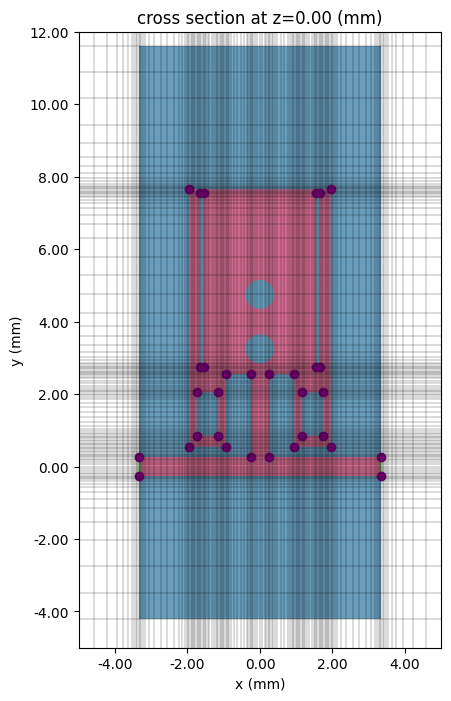

In [30]:
# In-plane
fig, ax = plt.subplots(figsize=(8, 8))
tcm2.plot_sim(z=0, ax=ax, monitor_alpha=0)
tcm2.simulation.plot_grid(z=0, ax=ax, hlim=(-5 * mm, 5 * mm), vlim=(-5 * mm, 12 * mm))
plt.show()

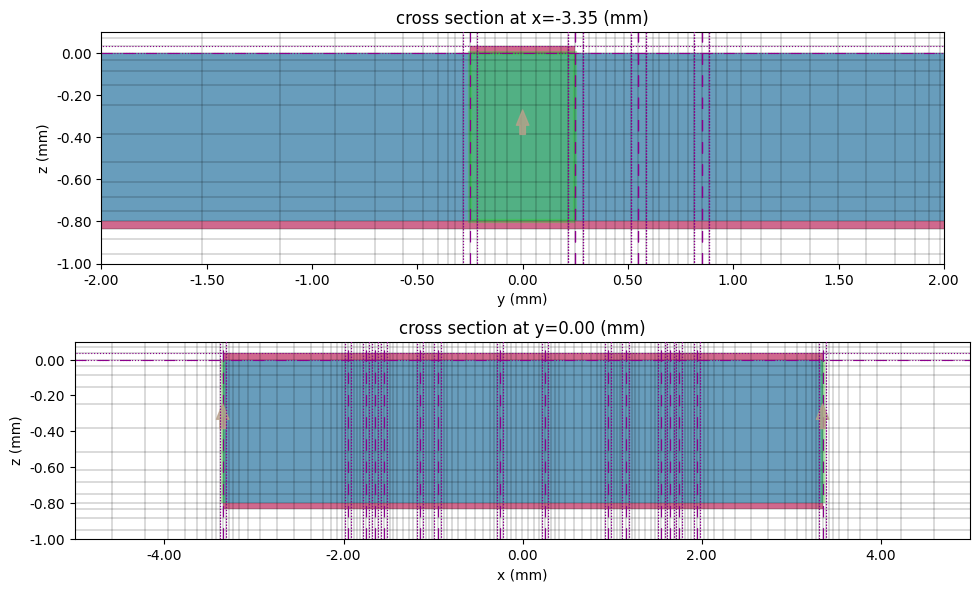

In [31]:
# Cross section and port
fig, ax = plt.subplots(2, 1, figsize=(10, 6), tight_layout=True)
tcm2.plot_sim(x=-MH / 2 - MC, ax=ax[0], monitor_alpha=0)
tcm2.simulation.plot_grid(
    x=-MH / 2 - MC, ax=ax[0], hlim=(-2 * mm, 2 * mm), vlim=(-1 * mm, 0.1 * mm)
)
tcm2.plot_sim(y=0, ax=ax[1], monitor_alpha=0)
tcm2.simulation.plot_grid(y=0, ax=ax[1], hlim=(-5 * mm, 5 * mm), vlim=(-1 * mm, 0.1 * mm))
ax[1].set_aspect(2)
plt.show()

### Run Simulation

In [32]:
tcm_data_modified = td.web.run(
    tcm2, task_name="WPD modified resonator", path="data/tcm_data_modified.hdf5"
)

16:42:01 EST Created task 'WPD modified resonator' with resource_id             
             'sid-2fd8bc8f-9f13-4861-9d46-fbf3f4065da0' and task_type           
             'TERMINAL_CM'.

             View task using web UI at                                          
             ]8;id=103608;https://tidy3d.simulation.cloud/rf?taskId=pa-fe063c19-a2e2-41ce-b35d-850e942447d2\'https://tidy3d.simulation.cloud/rf?]8;;\]8;id=66088;https://tidy3d.simulation.cloud/rf?taskId=pa-fe063c19-a2e2-41ce-b35d-850e942447d2\taskId]8;;\]8;id=103608;https://tidy3d.simulation.cloud/rf?taskId=pa-fe063c19-a2e2-41ce-b35d-850e942447d2\=]8;;\]8;id=225037;https://tidy3d.simulation.cloud/rf?taskId=pa-fe063c19-a2e2-41ce-b35d-850e942447d2\pa]8;;\]8;id=103608;https://tidy3d.simulation.cloud/rf?taskId=pa-fe063c19-a2e2-41ce-b35d-850e942447d2\-fe063c19-a2e2-41ce-b3]8;;\
             ]8;id=103608;https://tidy3d.simulation.cloud/rf?taskId=pa-fe063c19-a2e2-41ce-b35d-850e942447d2\5d-850e942447d2']8;;\.

             Task folder: ]8;id=626670;https://tidy3d.simulation.cloud/folders/f89aec3e-3357-4624-9c24-096a87582f12\'default']8;;\.

Output()

16:42:08 EST Maximum FlexCredit cost: 0.223. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' after run.

16:42:09 EST Subtasks status - WPD modified resonator                           
             Group ID: 'pa-fe063c19-a2e2-41ce-b35d-850e942447d2'

Output()

             Batch status = preprocess

16:42:15 EST Batch status = running

16:42:56 EST Batch status = postprocess

16:43:09 EST Modeler has finished running successfully.

             Billed flex credit cost: 0.089.

Output()

16:43:11 EST Loading component modeler data from data/tcm_data_modified.hdf5

### Results

#### Field Profile

In [33]:
sim_data2 = tcm_data_modified.data["LP1"]

As before, we plot the field amplitude profile within the pass- and stopbands. 

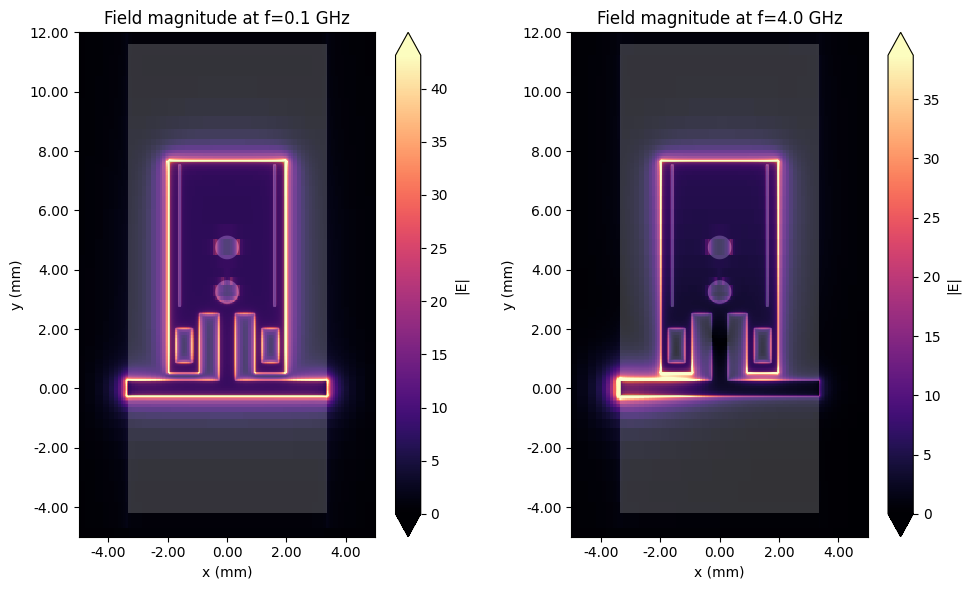

In [34]:
# Field plots
fig, ax = plt.subplots(1, 2, figsize=(10, 6), tight_layout=True)
sim_data2.plot_field("field in-plane", "E", val="abs", f=f_min, ax=ax[0])
ax[0].set_title(f"Field magnitude at f={f_min / 1e9:.1f} GHz")
sim_data2.plot_field("field in-plane", "E", val="abs", f=f0, ax=ax[1])
ax[1].set_title(f"Field magnitude at f={f0 / 1e9:.1f} GHz")
for axis in ax:
    axis.set_xlim(-5 * mm, 5 * mm)
    axis.set_ylim(-5 * mm, 12 * mm)
plt.show()

#### S-parameters

S-parameters for the modified resonator are extracted below. 

In [35]:
smat2 = tcm_data_modified.smatrix()
S11_2 = np.conjugate(smat2.data.isel(port_in=0, port_out=0))
S21_2 = np.conjugate(smat2.data.isel(port_in=0, port_out=1))
S11dB_2 = 20 * np.log10(np.abs(S11_2))
S21dB_2 = 20 * np.log10(np.abs(S21_2))

Below, we compare the insertion and return loss of the two resonator designs. Notice that the S21 amplitude falls off much more quickly past 2 GHz in the modified resonator, indicating a sharper filter response. 

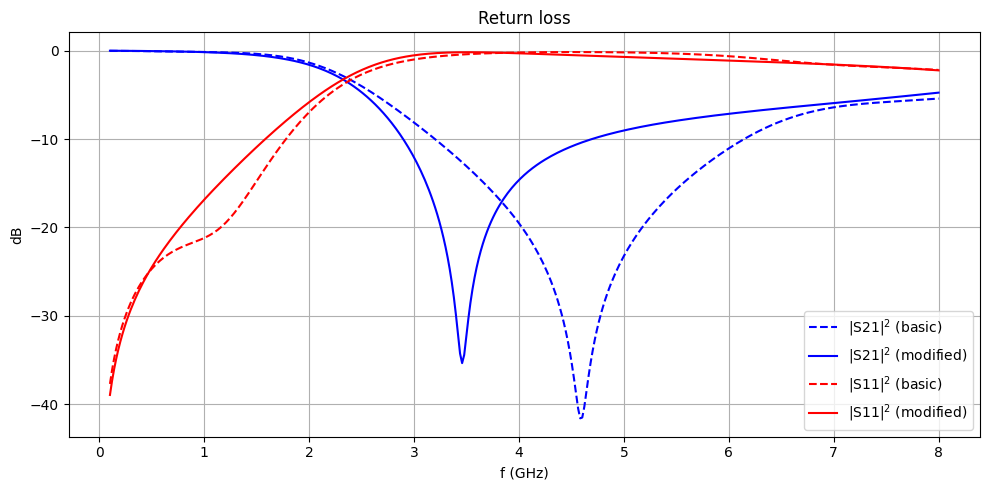

In [36]:
fig, ax = plt.subplots(figsize=(10, 5), tight_layout=True)
ax.plot(freqs / 1e9, S21dB, "b--", label="|S21|$^2$ (basic)")
ax.plot(freqs / 1e9, S21dB_2, "b", label="|S21|$^2$ (modified)")
ax.plot(freqs / 1e9, S11dB, "r--", label="|S11|$^2$ (basic)")
ax.plot(freqs / 1e9, S11dB_2, "r", label="|S11|$^2$ (modified)")
ax.set_title("Return loss")
ax.set_xlabel("f (GHz)")
ax.set_ylabel("dB")
ax.legend()
ax.grid()
plt.show()

#### Roll-off rate

We calculate and compare the ROR below. 

In [37]:
print(
    f"Calculated ROR \n -- Basic LC resonator: {calculate_ROR(S21dB):.2f} dB/GHz \n -- Modified resonator: {calculate_ROR(S21dB_2):.2f} dB/GHz"
)

Calculated ROR 
 -- Basic LC resonator: 13.02 dB/GHz 
 -- Modified resonator: 23.98 dB/GHz


The modified resonator shows an almost 2x improvement in ROR compared to the basic design.

#### Benchmark Comparison

For benchmarking purposes, we compare the computed S-parameters with results from an independent simulation run on a commercial FEM solver. We find excellent agreement.

In [38]:
# Import benchmark data
freqs_ben, S11dB_ben, S21dB_ben = np.genfromtxt(
    "./misc/wpd-part1-fem.csv", delimiter=",", unpack=True
)

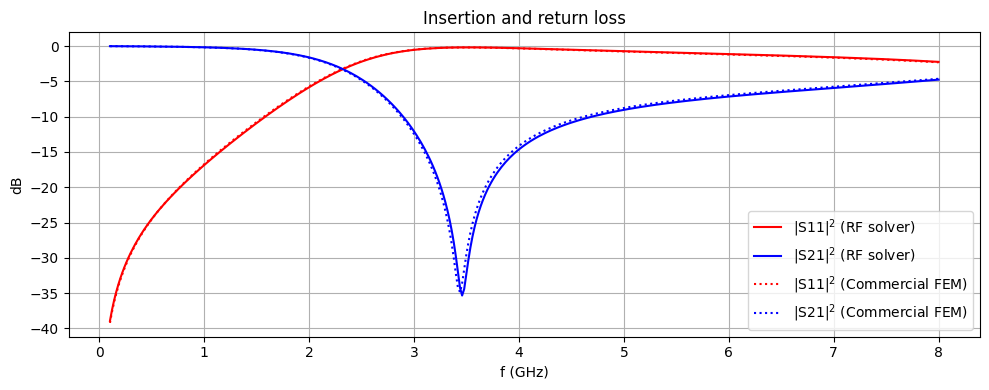

In [39]:
# Plot insertion and return loss
fig, ax = plt.subplots(figsize=(10, 4), tight_layout=True)
ax.plot(freqs / 1e9, S11dB_2, "r", label="|S11|$^2$ (RF solver)")
ax.plot(freqs / 1e9, S21dB_2, "b", label="|S21|$^2$ (RF solver)")
ax.plot(freqs_ben, S11dB_ben, "r:", label="|S11|$^2$ (Commercial FEM)")
ax.plot(freqs_ben, S21dB_ben, "b:", label="|S21|$^2$ (Commercial FEM)")
ax.set_title("Insertion and return loss")
ax.set_xlabel("f (GHz)")
ax.set_ylabel("dB")
ax.legend()
ax.grid()
plt.show()

## Conclusion

In this notebook, we compared two different low pass filter designs with the goal of improving ROR performance above 2 GHz. In the next notebook, we will investigate adding a harmonic suppression circuit to improve stopband performance. 
* [Designing a power divider for wireless communications part 2: Adding harmonic suppression](https://www.flexcompute.com/tidy3d/examples/notebooks/WPDHarmonicSuppression2/)
* [Designing a power divider for wireless communications part 3: Full divider structure](https://www.flexcompute.com/tidy3d/examples/notebooks/WPDHarmonicSuppression3/)

## Reference

[1] Moloudian, G., Soltani, S., Bahrami, S. et al. Design and fabrication of a Wilkinson power divider with harmonic suppression for LTE and GSM applications. Sci Rep 13, 4246 (2023). https://doi.org/10.1038/s41598-023-31019-7